<a href="https://colab.research.google.com/github/peppefdf/Generate_stops/blob/main/Generate_stops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


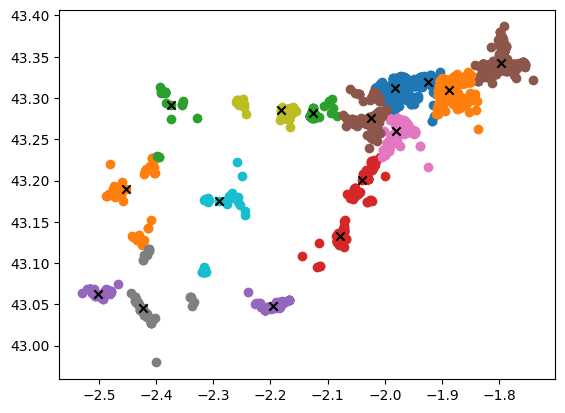

Closest 3 stops for cluster  0 :
                                         name    operator public_transport  \
element_type osmid                                                           
node         316073088                 Pasaia       Renfe    stop_position   
             621188120  Avenida Galtzalaborda  Ekialdebus         platform   
             621188121     Ambulatorio Beraun  Ekialdebus         platform   

                       railway train                   geometry   highway  \
element_type osmid                                                          
node         316073088    stop   yes  POINT (-1.91706 43.31899)       NaN   
             621188120     NaN   NaN  POINT (-1.91272 43.31165)  bus_stop   
             621188121     NaN   NaN  POINT (-1.91159 43.31344)  bus_stop   

                       bench  bin  bus  ... network:wikidata ref_name noexit  \
element_type osmid                      ...                                    
node         316073088   NaN  

In [7]:
#%pip install osmnx

import numpy as np
import osmnx as ox
import pandas as pd
import folium
import random
import sklearn
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from google.colab import drive

#n_skip = 10
n_clusters = 16

workers_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CSL_GIPUZKOA/Accessibility_Map/workers_eskuzaitzeta.csv", encoding='latin-1')

#lat_lon = workers_df[['O_lat', 'O_long']][::n_skip] # take every n elements
lat_lon = workers_df[['O_lat', 'O_long']].values.tolist()

ori_lat = 43.13525255625577
ori_lon = -2.080054227169231

map = folium.Map(location=[ori_lat, ori_lon], zoom_start=8)
for i in range(len(lat_lon)):
    lat = lat_lon[i][0]
    lon = lat_lon[i][1]
    folium.Marker((lat,lon)).add_to(map)

model = KMeans(n_clusters=n_clusters)
# fit the model
model.fit(lat_lon)
# assign a cluster to each example
yhat = model.predict(lat_lon)
# retrieve unique clusters
clusters = np.unique(yhat)

centers = np.array(model.cluster_centers_)

cont_centers = 0
for cluster in clusters:
 X = []
 Y = []
 # get row indexes for samples with this cluster
 row_ix = np.where(yhat == cluster)
 # create scatter of these samples
 dist = []
 for i_cl in range(len(row_ix[0])):

     # calculate Euclidean distance of each point from cluster center
     d = sum((p-q)**2 for p, q in zip(centers[cont_centers], lat_lon[row_ix[0][i_cl]]))**.5
     dist.append(d)
     X.append(lat_lon[row_ix[0][i_cl]][0])
     Y.append(lat_lon[row_ix[0][i_cl]][1])

 # find index of the point with minimum distance from cluster center
 index_min = np.argmin(dist)
 # assign closest point to cluster center: this tries to avoid the cluster center to fall in the middle of nowhere
 centers[cont_centers][0] = lat_lon[row_ix[0][index_min]][0]
 centers[cont_centers][1] = lat_lon[row_ix[0][index_min]][1]

 cont_centers+=1
 plt.scatter(Y,X)

# plot centers
#centers = np.array(model.cluster_centers_)
plt.scatter(centers[:,1], centers[:,0], marker="x", color='black')
plt.show()

tags = {'highway':'bus_stop',
        'public_transport':['stop_position','platform']}
for i in range(len(centers)):
    lat = centers[i][0]
    lon = centers[i][1]
    try:
       # get 3 closest (1500 meters) bus stops
       gdf = ox.features.features_from_point((lat, lon), dist=1500, tags=tags)
       print('Closest 3 stops for cluster ',i,':')
       print(gdf.head(3))
    except:
       print('stops not found for cluster ',i)
       print(centers[i])
    print()

map
